In [1]:
from matplotlib import pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
import os

from bids import BIDSLayout

In [2]:
layout = BIDSLayout('bids_temp', derivatives = True)

## Motor task (encoding model)

In [3]:
subjects = layout.get_subjects(scope = 'voxelwise')
print(subjects)

['01', 'dd', 'gg', 'uu']


In [4]:
print('\nANN-based encoding model vs. at-chance prediction')
print('whole-brain p-values (one-tailed R2-max):\n')
for sub in subjects:
    f = layout.get(subject = sub, desc = 'model', suffix = 'r2')[0]
    H0 = np.load(f).max(1) # maximum R2 over vertices/voxels
    max_r2 = H0[0]
    p = (H0 >= max_r2).mean()
    print('sub-%s: R2-max = %.03f, p ='%(sub, max_r2), p)

min_possible = 1 / H0.size
print('\nMinimum possible p-value:', min_possible)


ANN-based encoding model vs. at-chance prediction
whole-brain p-values (one-tailed R2-max):

sub-01: R2-max = 0.287, p = 0.0001999600079984003
sub-dd: R2-max = 0.191, p = 0.0001999600079984003
sub-gg: R2-max = 0.265, p = 0.0001999600079984003
sub-uu: R2-max = 0.160, p = 0.0001999600079984003

Minimum possible p-value: 0.0001999600079984003


In [5]:
print('\nANN-based encoding model vs. control model,')
print('whole-brain p-values (one-tailed TFCE):\n')
for sub in subjects:
    f = layout.get(subject = sub, desc = 'difference', suffix = 'tfce')[0]
    stat = np.load(f).max()
    f = layout.get(subject = sub, desc = 'difference', suffix = 'pvals')[0]
    p = np.load(f).min()
    print('sub-%s: TFCE statistic = %.03f, p ='%(sub, stat), p)


ANN-based encoding model vs. control model,
whole-brain p-values (one-tailed TFCE):

sub-01: TFCE statistic = 0.665, p = 0.0005998800239952009
sub-dd: TFCE statistic = 0.095, p = 0.029994001199760048
sub-gg: TFCE statistic = 0.048, p = 0.04939012197560488
sub-uu: TFCE statistic = 0.003, p = 0.946010797840432


## Agency task (behavior and decoding model)

In [6]:
subjects = layout.get_subjects(scope = 'decoding')
print(subjects)

['01', 'dd', 'gg']


In [7]:
def print_gee(sub):
    df = layout.get(subject = sub, desc = 'predictions', suffix = 'logodds')[0].get_df()
    mod = smf.gee(
        'y ~ latency + theory', 
        groups = df.run, # random effect of run
        cov_struct = sm.cov_struct.Exchangeable(), 
        family = sm.families.Binomial(),
        data = df
    )
    optim_params = dict(maxiter = 100, first_dep_update = 20, params_niter = 10)
    res = mod.fit(**optim_params) 
    print(res.summary())
    print('\nLongform p-values:\n')
    print(res.pvalues)
    return res.pvalues['latency']

p_sensitivity = dict()
p_sensitivity['01'] = print_gee('01')

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  877
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  55
                      Estimating Equations   Max. cluster size:                 112
Family:                           Binomial   Mean cluster size:                97.4
Dependence structure:         Exchangeable   Num. iterations:                    27
Date:                     Tue, 04 Jun 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         14:03:16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8166      0.968     -2.910      0.004      -4.714      -0.919
latency

In [8]:
p_sensitivity['dd'] = print_gee('dd')

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  853
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  71
                      Estimating Equations   Max. cluster size:                 110
Family:                           Binomial   Mean cluster size:                94.8
Dependence structure:         Exchangeable   Num. iterations:                    26
Date:                     Tue, 04 Jun 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         14:03:16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2995      0.203     -1.473      0.141      -0.698       0.099
latency

In [9]:
p_sensitivity['gg'] = print_gee('gg')

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  926
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  71
                      Estimating Equations   Max. cluster size:                 113
Family:                           Binomial   Mean cluster size:               102.9
Dependence structure:         Exchangeable   Num. iterations:                    26
Date:                     Tue, 04 Jun 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         14:03:17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5248      0.276      1.904      0.057      -0.016       1.065
latency

In [10]:
def plot_sub_line(sub, color, ax, a = .5):
    df = layout.get(subject = sub, scope = 'betaprep', suffix = 'events')[0].get_df() 
    ax.scatter(df.latency[~df.exclude]*1e3, df.response_time[~df.exclude]*1e3, color = color, label = 'sub-%s'%sub, alpha = a)
    ax.scatter(df.latency[df.exclude]*1e3, df.response_time[df.exclude]*1e3, facecolors = 'none', edgecolors = color, alpha = .16)
    r = 600
    ax.plot([0,r], [0,r], color = 'black', linestyle = '--')
    ax.set_xlim(0, r)
    ax.set_ylim(0, r)


In [11]:
def load_all_trials(sub):
    '''
    including baseline block trials, which weren't used in decoding, 
    so we can visualize natural reaction times
    '''
    baseline = layout.get(subject = sub, task = 'agency', run = 1, suffix = 'events')[0].get_df()
    baseline['run'] = 1
    baseline['exclude'] = False
    baseline['pressed_first'] = True
    baseline['agency'] = True
    baseline = baseline[['run', 'trial_type', 'agency', 'response_time', 'latency', 'pressed_first', 'exclude']]
    df = layout.get(subject = sub, scope = 'betaprep', suffix = 'events')[0].get_df()
    df = df[['run', 'trial_type', 'agency', 'response_time', 'latency', 'pressed_first', 'exclude']]
    df = pd.concat([baseline, df])
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df.agency[df.pressed_first] = 'actual agency'
        df.agency[df.agency == True] = 'perceived agency'
        df.agency[df.agency == False] = 'no agency'
    return df

def plot_sub_trials(sub, ax, legend = False):
    df = load_all_trials(sub)
    df.response_time *= 1e3
    df = df[(~df.exclude) | df.pressed_first]
    with sns.color_palette("pastel"):
        sns.stripplot(
            data = df, 
            x = 'run', y = 'response_time', 
            hue = 'agency', 
            dodge = True,
            #log_scale = False,
            #alpha = .5,
            marker = '.', 
            jitter = .25,
            ax = ax
        )
    ax.axvline(.25, label = 'stimulation starts', color = 'black', linestyle = 'dotted')
    ax.set_ylabel("\"reaction\" time (ms)")
    ax.set_ylim(0, 600)
    if legend:
        ax.legend(loc = 'center right').set_title(None)
    else:
        ax.get_legend().remove()
    ax.text(.5, 560, 'sub-%s'%sub, fontweight = 'bold')
    ax.text(4, 560, r'(sensitivity: $p = %.03f$)'%p_sensitivity[sub])


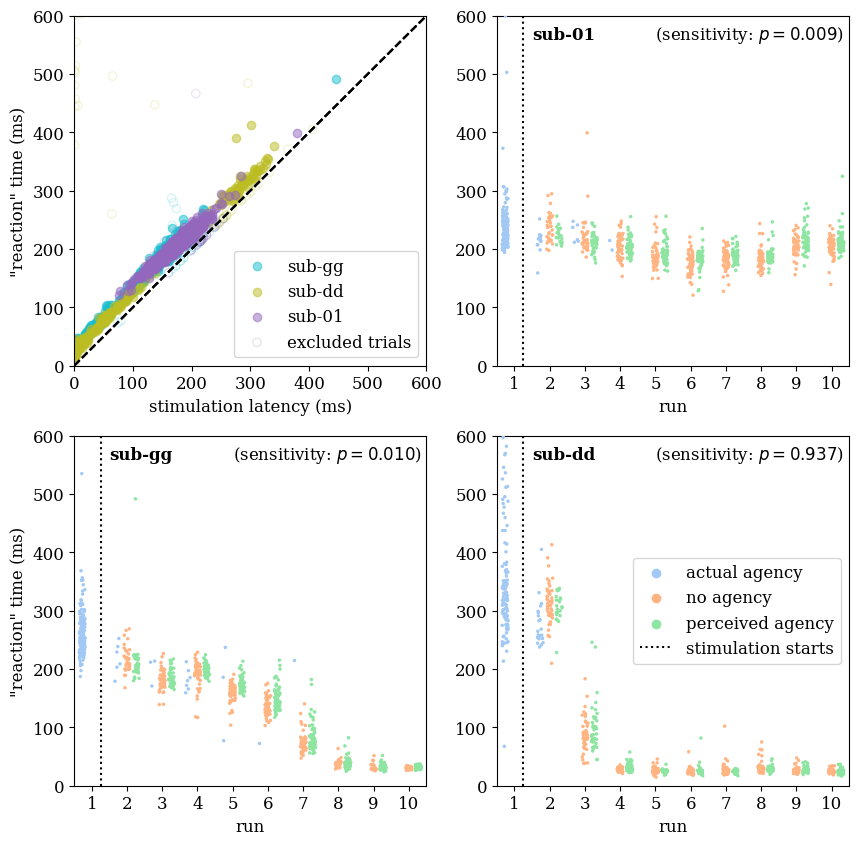

In [12]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize = (10, 10))
gs = gridspec.GridSpec(2, 2, wspace = .2, hspace = .2)

# plot agency over runs
ax = fig.add_subplot(gs[0, 1])
plot_sub_trials('01', ax)
ax.set_ylabel(None)
ax = fig.add_subplot(gs[1, 0])
plot_sub_trials('gg', ax)
ax = fig.add_subplot(gs[1, 1])
plot_sub_trials('dd', ax, legend = True)
ax.set_ylabel(None)

# plot 
ax = fig.add_subplot(gs[0, 0])
plot_sub_line('gg', 'tab:cyan', ax)
plot_sub_line('dd', 'tab:olive', ax)
plot_sub_line('01', 'tab:purple', ax)
ax.scatter([], [], facecolors = 'none', edgecolors = 'gray', alpha = .2, label = "excluded trials")
ax.set_xlabel("stimulation latency (ms)")
ax.set_ylabel("\"reaction\" time (ms)")
ax.legend()

fpath = os.path.join('figures', 'behavior.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

In [13]:
def extract(f):
    H0 = np.load(f)
    auc = H0[0]
    p = (H0 >= auc).mean()
    return auc, p

def get_sub_results(sub, return_diffs = False):
    if return_diffs:
        fs = [f for f in layout.get(subject = sub, suffix = 'auc') if 'V' in f.entities['desc']]
    else:
        fs = [f for f in layout.get(subject = sub, suffix = 'auc') if 'V' not in f.entities['desc']]
    aucs = {f.entities['desc']: extract(f)[0] for f in fs}
    ps = {f.entities['desc']: extract(f)[1] for f in fs}
    return aucs, ps

def get_decoding_results(return_diffs = False):
    subs = layout.get_subjects(scope = 'decoding')
    res = [get_sub_results(sub, return_diffs) for sub in subs]
    aucs, ps = zip(*res)
    return pd.DataFrame(aucs, index = subs), pd.DataFrame(ps, index = subs)
    

auc, p = get_decoding_results()
print('AUROC:')
print(auc)
print('\np-values (vs. chance):')
print(p)

AUROC:
      cortex    theory  visuomotor
01  0.707364  0.600223    0.695929
dd  0.536430  0.520589    0.485726
gg  0.646709  0.637980    0.603157

p-values (vs. chance):
     cortex    theory  visuomotor
01  0.00020  0.000200     0.00020
dd  0.04819  0.167167     0.75045
gg  0.00020  0.000200     0.00020


In [14]:
diffs, p = get_decoding_results(return_diffs = True)
print(r'difference in AUROC:')
print(diffs)
print('\np-values (one-tailed):')
print(p)

difference in AUROC:
    cortexVtheory  cortexVvisuomotor  visuomotorVtheory
01       0.107141           0.011435           0.095706
dd       0.015841           0.050704          -0.034863
gg       0.008729           0.043552          -0.034823

p-values (one-tailed):
    cortexVtheory  cortexVvisuomotor  visuomotorVtheory
01       0.000200           0.298540           0.000200
dd       0.303739           0.023795           0.873825
gg       0.363927           0.038992           0.891422
